### 11. Układ 100-stanowy skorelowany

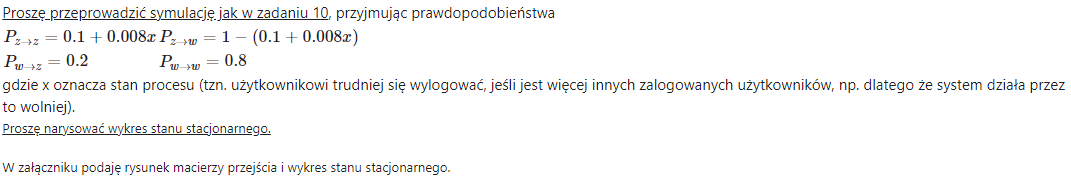

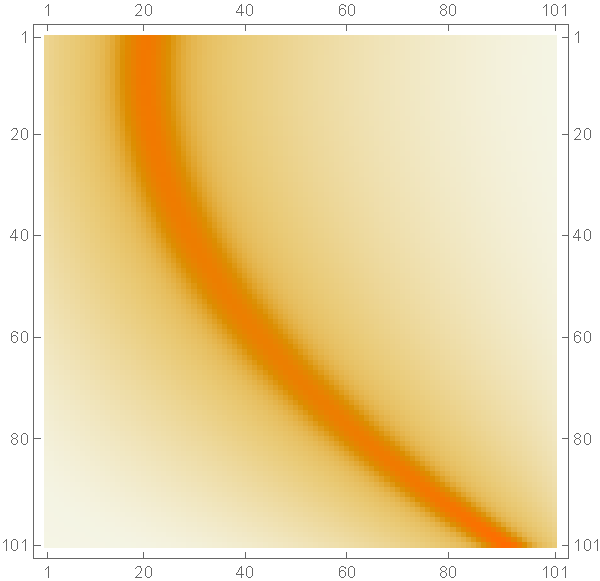

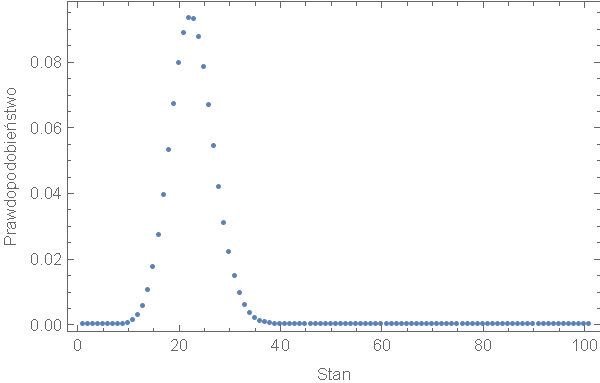

In [2]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

In [6]:
N_LOGGED = N_STATES = 100

Pwz, Pww = 0.2, 0.8
def Pwz(*_): return 0.2 #?
def Pww(*_): return 0.8 #?
def Pzz(state):
    return 0.1 + 0.008*state
def Pzw(state):
    return 1-Pzz(state) #?

In [23]:
# transition matrix P[i, j] represents the probability of
# going from state i (i users logged in) to state j (j users logged in)
P = np.zeros((N_STATES, N_STATES))

for i in range(N_LOGGED):    
    # prob of ...
    stay_logged_in_probs = binom.pmf(range(i+1), i, Pzz(i)) 
    # zwraca pp dla k od 0 do i włącznie // O WIELE szybsze (17s/11s vs 34s) niż w ostatniej pętli
    for j in range(N_LOGGED):
        users_logged_out = N_LOGGED - i
        
        # probability of j - k users logging in (where k is the number who stayed logged in)
        for k in range(max(0, j - users_logged_out), min(i, j) + 1):
            # stay_logged_in_probs = binom.pmf(k, i, Pzz)
            logged_in_probs = binom.pmf(j - k, users_logged_out, Pwz(i))
            P[i, j] += logged_in_probs * stay_logged_in_probs[k]

Widać, że czym więcej zalogowanych użytkowników, tym prawdopodobieństwa przejść przesuwają się jeszcze bardziej (nieliniowo) w prawo, ponieważ przy dużej liczbie użytkowników maleje prawdopodobieństwo wylogowania się. A więc maleje prawdopodobieństwo zmiany stanu na niższy. Obrazek odpowiada podanemu w treści zadania.

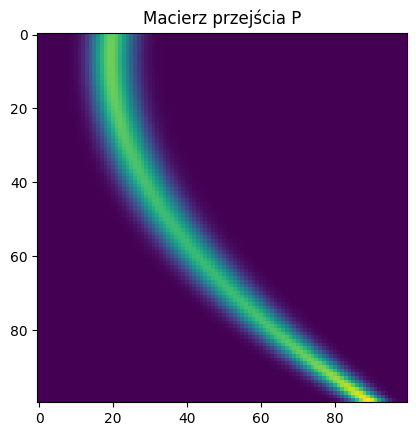

In [24]:
plt.title("Macierz przejścia P")
plt.imshow(P);

Znajdowanie stanu stacjonarnego (potęgi macierzy P):

In [25]:
# make that a function?
err = 999
power = 1
P_current = P.copy()

while err > 1e-5:
    P_prev = P_current.copy()
    P_current = P_current @ P # or maybe raise P to a specific power using linalg.matrix_power
    power += 1
    # err = np.abs(P_current[0,0]-P_prev[0,0])
    err = np.linalg.norm(P_current - P_prev) # Frobenius norm: https://mathworld.wolfram.com/FrobeniusNorm.html#:~:text=The%20Frobenius%20norm%2C%20sometimes%20also,considered%20as%20a%20vector%20norm.
    print(f"power: {power}, err: {err}")

power: 2, err: 2.4164384251979576
power: 3, err: 1.6703702379221868
power: 4, err: 1.160472675380579
power: 5, err: 0.7404702205369861
power: 6, err: 0.38243481021066983
power: 7, err: 0.14645996825498034
power: 8, err: 0.04459821620801447
power: 9, err: 0.012196537355264506
power: 10, err: 0.003214145942435835
power: 11, err: 0.0008376368528066593
power: 12, err: 0.00021759273809906417
power: 13, err: 5.6471493949425485e-05
power: 14, err: 1.465203054394362e-05
power: 15, err: 3.801305803920444e-06


In [36]:
# https://stackoverflow.com/questions/46539431/np-random-choice-probabilities-do-not-sum-to-1 // for the 97th row
for row in P:
    row /= row.sum()

In [39]:
N = 10_000 # 1_000 ~ 40 secs // 10_000 ~ 3 mins
STEPS = power
ending_states = np.zeros((N_STATES, N), dtype=int) # or empty?
err = 999

for starting_state in range(N_STATES):
    # print(starting_state)
    for n in range(N):
        state = starting_state
        for step in range(STEPS):
            state = np.random.choice(N_STATES, p=P[state]) # transition to a new state
        ending_states[starting_state, n] = state

In [40]:
# https://numpy.org/doc/stable/reference/generated/numpy.bincount.html
stationary_state_estims = np.array([
    np.bincount(ending_states[starting_state], minlength=N_STATES)/N
    for starting_state in range(N_STATES)
])
print(stationary_state_estims.shape)

(100, 100)


Stan stacjonarny macierzy przejść P odpowiada podanemu w treści zadania.

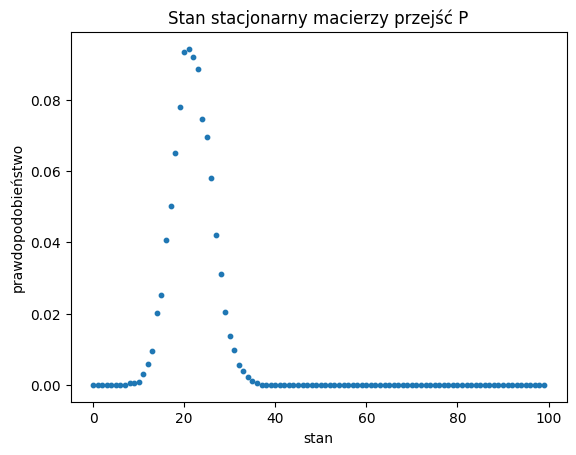

In [41]:
plt.title("Stan stacjonarny macierzy przejść P")
plt.xlabel("stan")
plt.ylabel("prawdopodobieństwo")
plt.scatter(range(N_STATES), stationary_state_estims[0], s=10);